## Case 1: One Line switch is faulted


Single Line Diagram of system

![alt text](case1.png "Title")

Importing Data and packages

In [27]:
import pandas as pd
import networkx as nx
import numpy as np
import params as params
import matplotlib.pyplot as plt

from pypower.api import ppoption, runpf, case9

grid = case9()
ppopt = ppoption(PF_ALG=1)

line_data = pd.DataFrame(grid['branch'],
                     columns=['fbus', 'tbus', 'r', 'x', 'b', 'rateA', 'rateB', 'rateC', 'ratio', 'angle', 'status', 'angmin', 'angmax'])
line_data = line_data.astype({'fbus': int, 'tbus': int, 'status': int})

bus_data = pd.DataFrame(grid['bus'],
                        columns=['bus_i', 'type', 'Pd', 'Qd', 'Gs', 'Bs', 'area', 'Vm', 'Va', 'baseKV', 'zone', 'Vmax', 'Vmin'])
bus_data = bus_data.astype({'bus_i': int, 'type': int})

gen_data = pd.DataFrame(grid['gen'], columns=['bus', 'Pg', 'Qg', 'Qmax', 'Qmin', 'Vg', 'mBase', 'status', 'Pmax', 'Pmin', 'Pc1', 'Pc2',
     'Qc1min', 'Qc1max', 'Qc2min', 'Qc2max', 'ramp_agc', 'ramp_10', 'ramp_30', 'ramp_q', 'apf'])
gen_data = gen_data.astype({'bus': int, 'status': int})

DERs = set(gen_data['bus'])
CLs = set(bus_data['bus_i'][bus_data['Pd'] > 10])
bus_data

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va,baseKV,zone,Vmax,Vmin
0,1,3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
1,2,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
2,3,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
3,4,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
4,5,1,90.0,30.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
5,6,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
6,7,1,100.0,35.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
7,8,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
8,9,1,125.0,50.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9



#### Modification to the standard 6 bus, 3 generator system:
`Switch in the line between bus 9 and 4 is changed to open from closed.`


In [28]:
line_data.loc[8, 'status'] = 0
grid['branch'] = line_data.values
line_data

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1,4,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
1,4,5,0.0170,0.0920,0.158,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
2,5,6,0.0390,0.1700,0.358,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
3,3,6,0.0000,0.0586,0.000,300.0,300.0,300.0,0.0,0.0,1,-360.0,360.0
4,6,7,0.0119,0.1008,0.209,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
5,7,8,0.0085,0.0720,0.149,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
6,8,2,0.0000,0.0625,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
7,8,9,0.0320,0.1610,0.306,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
8,9,4,0.0100,0.0850,0.176,250.0,250.0,250.0,0.0,0.0,0,-360.0,360.0


Verifying normal operation of system after change using power flow calculation

In [29]:
pf_res, success = runpf(grid)
print('power flow converged') if success else print('power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)


Newton's method power flow converged in 5 iterations.

Converged in 0.01 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0        -900.0 to 900.0
Generators         3     On-line Capacity       820.0        -900.0 to 900.0
Committed Gens     3     Generation (actual)    325.0              91.0
Loads              3     Load                   315.0             115.0
  Fixed            3       Fixed                315.0             115.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           9     Losses (I^2 * Z)        10.68             85.15
Transformers       0     Branc

Adding edges and weights to graph

In [30]:
from utilities import Utils
utils = Utils()
G, status = utils.make_graph(line_data)


Calculation of N-1 and N-2 branch resiliency for the network

In [31]:
# Calculation of N-1 branch resiliency
edges = G.edges
networks = []
for u, v in edges:
    G.remove_edge(u, v)
    networks.append(list(G.edges))
    G.add_edge(u, v)

rsl = params.ratio_source_load(networks, CLs, DERs)
ops = params.switch_ops(networks, status)
cen = params.agg_centrality(networks)
obs = params.overlapping_branches(networks)
apl = params.avg_path_length(networks)

df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
df = df.T
df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
df['resiliency'] = np.exp(-df['wtd_mean'])
print('Resiliency of network considering N-1 branches: ', np.average(df['resiliency']))

# Calculation of N-2 branch Resiliency
networks = []
for i, (u, v) in enumerate(edges):
    G.remove_edge(u, v)
    for j, (l, r) in enumerate(edges):
        if i == j: continue
        G.remove_edge(l, r)
        networks.append(list(G.edges))
        G.add_edge(l, r)
    G.add_edge(u, v)

rsl = params.ratio_source_load(networks, CLs, DERs)
ops = params.switch_ops(networks, status)
cen = params.agg_centrality(networks)
obs = params.overlapping_branches(networks)
apl = params.avg_path_length(networks)

df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
df = df.T
df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
df['resiliency'] = np.exp(-df['wtd_mean'])
print('Resiliency of network considering N-2 branches: ', np.average(df['resiliency']))

    

Resiliency of network considering N-1 branches:  0.37123902731142183
Resiliency of network considering N-2 branches:  0.35636703408168346


Visualizing modified network

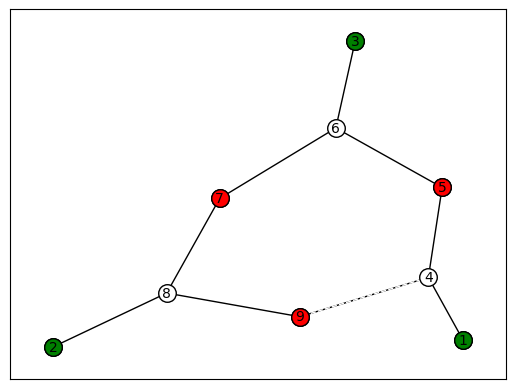

In [32]:
def plot_graph(G):
    pos = nx.layout.fruchterman_reingold_layout(G)
    options={
        'linewidths': 1,
        'edgecolors': 'black',
        'node_size': 160
    }
    nx.draw_networkx_nodes(G, pos, bus_data['bus_i'], node_color='white', **options)
    nx.draw_networkx_nodes(G, pos, CLs, node_color='red', **options)
    nx.draw_networkx_nodes(G, pos, DERs, node_color='green', **options)
    nx.draw_networkx_edges(G, pos, G.edges)
    nx.draw_networkx_edges(G, pos, [edge for edge in G.edges if status[edge] == 0], edge_color = 'white', style='dashed')
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10)
    plt.show()
plot_graph(G)


#### Simulating Contingency:
`Switch in the line between bus 9 and 8 is faulted resulting in islanding of bus 9.`

In [33]:
line_data = line_data.drop(7)
grid['branch'] = line_data.values
line_data

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1,4,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
1,4,5,0.0170,0.0920,0.158,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
2,5,6,0.0390,0.1700,0.358,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
3,3,6,0.0000,0.0586,0.000,300.0,300.0,300.0,0.0,0.0,1,-360.0,360.0
4,6,7,0.0119,0.1008,0.209,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
5,7,8,0.0085,0.0720,0.149,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
6,8,2,0.0000,0.0625,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
8,9,4,0.0100,0.0850,0.176,250.0,250.0,250.0,0.0,0.0,0,-360.0,360.0


Visualizing the network after contingency

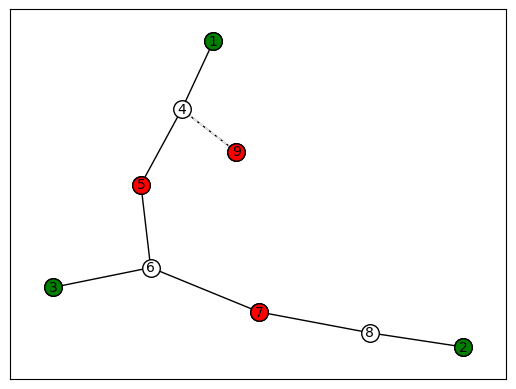

In [34]:
G, status = utils.make_graph(line_data)
plot_graph(G)

Power flow analysis of the network after contingency

In [35]:
try:
    pf_res, success = runpf(grid)
    print('Power flow converged') if success else print('Power flow did not converge')
except:
    print('Power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)

dgstrf info 13
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1

Newton's method power did not converge in 10 iterations.
Power flow did not converge
dgstrf info 1


/Users/kakiku/BTP/.venv/lib/python3.11/site-packages/pypower/newtonpf.py:100: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F)
/Users/kakiku/BTP/.venv/lib/python3.11/site-packages/pypower/pfsoln.py:44: RuntimeWarning: invalid value encountered in cast
  gen[on, QG] = Sbus.imag * baseMVA + bus[gbus, QD]    ## inj Q + local Qd


### Finding Networks to restore the islanded critical node

Finding all simple paths from each critical load to each source

In [36]:
path_list = utils.find_path_list(G, CLs, DERs)

All possible path combination calculation

In [37]:
FNs, raw_combs = utils.path_combinations(path_list)

### Calculating parameters to measure resiliency of possible network

Calculation of Parameter matrix

In [38]:
rsl = params.ratio_source_load(FNs, CLs, DERs)
ops = params.switch_ops(FNs, status)
cen = params.agg_centrality(FNs)
obs = params.overlapping_branches(FNs)
apl = params.avg_path_length(raw_combs)

df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
df = df.T
print(df)

     rsl  ops       cen       obs  apl
FN1  1.5  1.0  0.238095  0.166667  2.0
FN2  1.5  1.0  0.238095  0.166667  2.0
FN3  1.5  1.0  0.238095  0.166667  2.0
FN4  1.0  1.0  0.166667  0.000000  2.0


Calculation of weighted mean and resiliency

In [39]:
df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
df['resiliency'] = np.exp(-df['wtd_mean'])
print(df.sort_values('resiliency', ascending=False))

     rsl  ops       cen       obs  apl  wtd_mean  resiliency
FN4  1.0  1.0  0.166667  0.000000  2.0  0.958333    0.383532
FN1  1.5  1.0  0.238095  0.166667  2.0  1.153571    0.315508
FN2  1.5  1.0  0.238095  0.166667  2.0  1.153571    0.315508
FN3  1.5  1.0  0.238095  0.166667  2.0  1.153571    0.315508


Comparing line data before and after switching to the suggested network

In [40]:
print(line_data[['fbus', 'tbus', 'r', 'x', 'status']])
for u, v in FNs[3]:
    line_data.loc[(line_data.fbus == u) & (line_data.tbus == v), 'status'] = 1
    line_data.loc[(line_data.fbus == v) & (line_data.tbus == u), 'status'] = 1
grid['branch'] = line_data.values
print('-----------------------------------------------------------', '\n')
print(line_data[['fbus', 'tbus', 'r', 'x', 'status']])

   fbus  tbus       r       x  status
0     1     4  0.0000  0.0576       1
1     4     5  0.0170  0.0920       1
2     5     6  0.0390  0.1700       1
3     3     6  0.0000  0.0586       1
4     6     7  0.0119  0.1008       1
5     7     8  0.0085  0.0720       1
6     8     2  0.0000  0.0625       1
8     9     4  0.0100  0.0850       0
----------------------------------------------------------- 

   fbus  tbus       r       x  status
0     1     4  0.0000  0.0576       1
1     4     5  0.0170  0.0920       1
2     5     6  0.0390  0.1700       1
3     3     6  0.0000  0.0586       1
4     6     7  0.0119  0.1008       1
5     7     8  0.0085  0.0720       1
6     8     2  0.0000  0.0625       1
8     9     4  0.0100  0.0850       1


Visualizing network having highest resiliency

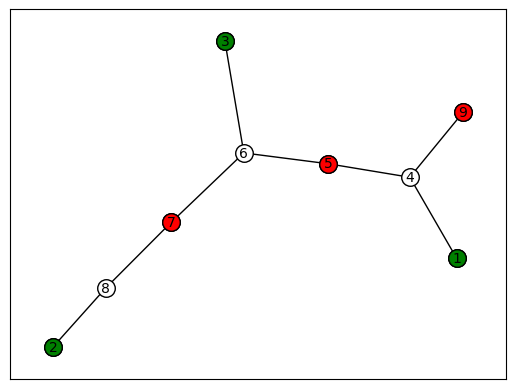

In [41]:
G, status = utils.make_graph(line_data)
plot_graph(G)

Verification for the feasibility for the operation of the network using power flow analysis

In [42]:
pf_res, success = runpf(grid)
print('Power flow converged') if success else print('Power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)


Newton's method power flow converged in 4 iterations.

Converged in 0.01 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0        -900.0 to 900.0
Generators         3     On-line Capacity       820.0        -900.0 to 900.0
Committed Gens     3     Generation (actual)    329.0             130.0
Loads              3     Load                   315.0             115.0
  Fixed            3       Fixed                315.0             115.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           8     Losses (I^2 * Z)        14.15            112.57
Transformers       0     Branc